# Updated ABA rate prediction model

* Original model with Vienna value and base change representation has r value of ~.887 (r^2 .786)
* ^Model including all Vienna and Mfold information has an r value of ~.894 (r^2 of .799)
* ^Model with pooling features has an r value of .919 (r^2 of .844). Test accuracy r of .900 (r^2 of .810)
* ^Deep learning model with all of the above variables has a training r value of .958 (r^2 of .917) with lower performance test (holdout data) r value of .930 (r^2 of .865)

In [3]:
import numpy as np
import pandas as pd
import edit_distance
from sklearn import linear_model, preprocessing
from sklearn.linear_model import HuberRegressor, Ridge
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib as mpl

## Original Model

**All if not most of the next cell is code from the last notebook**

In [4]:
# Time to load in the data
data = pd.read_csv("cr7_no_ceiling.csv")
#data = data[data["kd"] >= 1]
energies = pd.read_csv("subopt_attributes7.csv")
#energies = energies.drop(['mfold_opt', 'mfold_worst', 'mfold_mean', 'mfold_samples', 'mfold_std',
#                          'mfold_skew','mfold_median'], axis=1)
energies["sequence"] = energies.Sequence.str.slice(29, -32).str.replace("U", "T")
big_table = pd.merge(energies, data, on='sequence', how="inner")

#columns list needed when we add data later
cols = list(energies.columns)
cols.remove('Sequence')
cols.remove('sequence')

#now we want to add the ABA column to big_table
perfect_sequence = "TTTGATCTGAAATATTCAGGTC"
PERFECT_KD = big_table[big_table['sequence'] == perfect_sequence].iloc[0]['kd']
PERFECT_SEQ = big_table[big_table['sequence'] == perfect_sequence].iloc[0]['Sequence']
big_table['ABA'] = (big_table.kd/PERFECT_KD).apply(np.log)
big_table.head()

#This function recovers the sequence of changes (insertions/deletions/replacements)
#from the perfect sequence to the target sequence
def get_diff(perfect, x):
    output = []
    sm = edit_distance.SequenceMatcher(a=perfect, b=x)
    for row in sm.get_opcodes():
        if row[0] == "equal":
            continue
        elif row[0] == "insert":
            output.append((row[1], "insert", x[row[3]]))
        elif row[0] == "delete":
            output.append((row[1], "delete"))
        else:
            output.append((row[1], "replace", x[row[3]]))
    return output



# want to create a value mapping table of the changes
# the structure goes like this:
# [(index, i, A), (index, i, C), (index, i, G), (index, i  T),
#  (index, r, A), (index, r, C), (index, r, G), (index, r, T), (index, d)]
# index is the position on the rna, i is insertion, r is replacement, d is deletion,
# In the future we can try to have a way to combine these variables
def get_action(coord):
    if (coord % 9) == 0:
        return "INS A"
    if (coord % 9) == 1:
        return "INS C"
    if (coord % 9) == 2:
        return "INS G"
    if (coord % 9) == 3:
        return "INS T"
    if (coord % 9) == 4:
        return "REP A"
    if (coord % 9) == 5:
        return "REP C"
    if (coord % 9) == 6:
        return "REP G"
    if (coord % 9) == 7:
        return "REP T"
    if (coord % 9) == 8:
        return "DEL"
    

def get_position(coord):
    if len(coord) == 2:
        return coord[0]*9+8
    elif coord[1] == 'insert' and coord[2] == 'A':
        return coord[0]*9
    elif coord[1] == 'insert' and coord[2] == 'C':
        return coord[0]*9 + 1
    elif coord[1] == 'insert' and coord[2] == 'G':
        return coord[0]*9 + 2
    elif coord[1] == 'insert' and coord[2] == 'T':
        return coord[0]*9 + 3
    elif coord[1] == 'replace' and coord[2] == 'A':
        return coord[0]*9 + 4
    elif coord[1] == 'replace' and coord[2] == 'C':
        return coord[0]*9 + 5
    elif coord[1] == 'replace' and coord[2] == 'G':
        return coord[0]*9 + 6
    elif coord[1] == 'replace' and coord[2] == 'T':
        return coord[0]*9 + 7
    else:
        print ("INCORRECT COORDINATE")
        return -1
#Plots detailed results
def display(predicted, actual, title="Predicted vs Actual"):
    x,y = actual,predicted
    
    
    
    # definitions for the axes
    left, width = 0.02, 0.65
    bottom, height = 0.2, 0.65
    spacing = 0.02


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    #plt.title("Predicted vs Expected ABA for Linear Regression Model")



    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    #ax_scatter.scatter(predicted, actual)
    ax_scatter.hexbin(x, y, gridsize=(30,15),  cmap='Purples', edgecolors='none' )
    ax_scatter.plot(np.unique(predicted), np.poly1d(np.polyfit(x,
                                                x, 1))(np.unique(y)))

    ax_scatter.set_xlabel("Fit (ABA)", fontsize=15)
    ax_scatter.set_ylabel("Measured (ABA)", fontsize=15)
    # now determine nice limits by hand:
    binwidth = 0.25
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    #ax_scatter.set_xlim((-lim, lim))
    #ax_scatter.set_ylim((-lim, lim))

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(y, bins=bins,  color=(0.23, 0.06, 0.4))
    ax_histx.set_title(title,pad=15, fontsize=20)
    ax_histy.hist(x, bins=bins, orientation='horizontal',color=(0.23, 0.06, 0.4))

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    

    plt.show()
# to help analyze results (older version)
def display1(predicted, actual, title="Predicted vs Actual"):
    #plt.scatter(predicted, actual)
    plt.figure(num=1,figsize=(5,5))
    plt.hexbin(predicted, actual, gridsize=(15,15),  cmap='Purples', edgecolors='none' )
    plt.plot(np.unique(predicted), np.poly1d(np.polyfit(actual,
                                                actual, 1))(np.unique(predicted)))
    #plt.show()
    plt.xlabel("predicted ABA")
    plt.ylabel("actual ABA")
    plt.title(title)
    plt.show()
    #now we build the table that we will use for regressions
#think of data_matrix as input and output variable as output
seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
def create_matrix(get_seq=False):
    pruned_combined_data_matrix = []
    pruned_output = []
    seqs = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
                seqs.append(seq)
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    if get_seq:
        return X, y, seqs
    return X, y

In [5]:
big_table.tail()

,vienna_opt,vienna_worst,vienna_mean,vienna_samples,vienna_std,vienna_skew,vienna_median,vienna_worst_100,vienna_mean_100,Sequence,sequence,kd,kd_uncertainty,y_intercept,delta_y,count,ABA
4899,-16.1,-11.1,-11.751155,7964,0.659126,-1.631475,-11.6,-13.8,-14.382,GGGAAUGGAUCCACAUCUACGAAUUCGUUUUUGAUCUGAACAUAUU...,TTTGATCTGAACATATTCAGCGTC,2.954092e+02,14223.764442,11364.683187,24980.912260,156,2.589788
4900,-14.0,-9.0,-9.641244,22282,0.646120,-1.625597,-9.4,-12.3,-12.697,GGGAAUGGAUCCACAUCUACGAAUUCGUUUUUGAUCUAGGAAAUAU...,TTTGATCTAGGAAATATTCAGGTC,2.046213e-24,673487.905274,7.827600,10592.629235,111,-57.644625
4901,-13.0,-8.0,-8.654421,19985,0.654052,-1.585471,-8.5,-11.3,-11.667,GGGAAUGGAUCCACAUCUACGAAUUCGUUUUUGUCUGAAAUAUUCA...,TTTGTCTGAAATATTCAGTC,1.645201e+02,203842.192342,10399.034067,14825.459020,142,2.004459
4902,-14.3,-9.3,-9.936847,23044,0.645218,-1.632015,-9.7,-12.6,-13.005,GGGAAUGGAUCCACAUCUACGAAUUCGUUUUUGAUCUGAAAUAUUU...,TTTGATCTGAAATATTTATGTC,8.503963e+00,0.741894,10767.263714,23882.231024,104,-0.958041
4903,-13.9,-8.9,-9.567289,31430,0.672740,-1.622695,-9.4,-12.4,-12.871,GGGAAUGGAUCCACAUCUACGAAUUCGUUUUUGAUCUUGAAAUAUU...,TTTGATCTTGAAATATTCAGGTC,7.353077e+01,7.844505,9834.232313,24636.979687,119,1.199130


In [6]:
#def absolute_enumeration(seq):
#    for 

def create_matrix_0(randomize=True):
    max_len = 0
    for seq in seq_aba_pairs:
        max_len = max(max_len, len(seq))
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            #coords = get_diff(perfect_sequence, seq)
            #if len(coords) > 5:
            #    pass
            #else:
            row = [0 for i in range(4*max_len)]
            for i in range(len(seq)):
                if seq[i] == 'A':
                    row[i*4 + 0] = 1
                elif seq[i] == 'C':
                    row[i*4 + 1] = 1
                elif seq[i] == 'G':
                    row[i*4 + 2] = 1
                elif seq[i] == 'T':
                    row[i*4 + 3] = 1
                else:
                    print("Impossible happened check seq values", seq)
                #row[get_position(coord)] = 1
            #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
            pruned_combined_data_matrix.append(row)
            pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    if randomize:
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]
    
    return X, y

In [7]:
def hinge(x, exp=1):
    return min(x, 6**exp)
vhinge = np.vectorize(hinge)

In [8]:
X,y = create_matrix_0()

In [8]:
len(X[0])

96

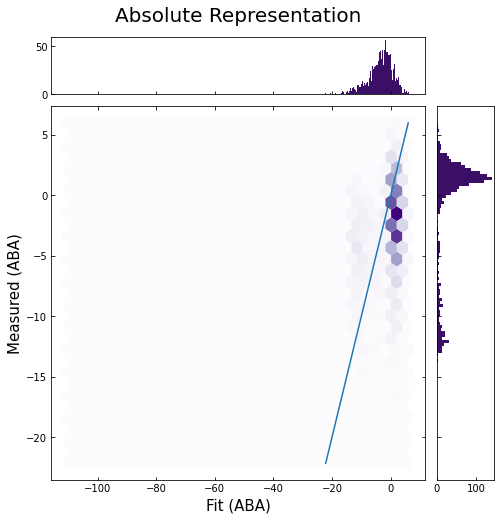

test correlation is 0.23972318850201652


In [9]:
#just to show that we aren't really over-fitting
cutoff = 3000

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(vhinge(predicted_output), y_test, title="Absolute Representation")
corr, p_value = pearsonr(vhinge(predicted_output), y_test)
print("test correlation is",corr)

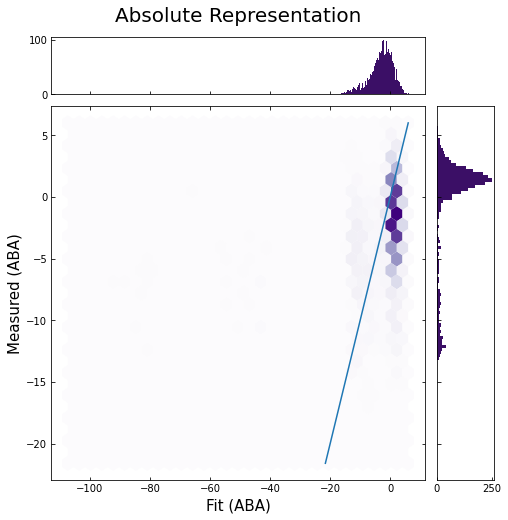

train correlation is 0.30497918645995203


In [10]:
predicted_output = reg.predict(X_train)
display(vhinge(predicted_output), y_train, title="Absolute Representation")
corr, p_value = pearsonr(vhinge(predicted_output), y_train)
print("train correlation is",corr)

In [11]:
reg.intercept_

-3.1699608211055113

In [12]:
X_test

array([[-0.13476529, -0.11596539, -0.11596539, ..., -0.8826238 ,
        -0.11692495, -0.11882207],
       [-0.13476529, -0.11596539, -0.11596539, ...,  1.13298554,
        -0.11692495, -0.11882207],
       [-0.13476529, -0.11596539, -0.11596539, ...,  1.13298554,
        -0.11692495, -0.11882207],
       ...,
       [-0.13476529, -0.11596539, -0.11596539, ...,  1.13298554,
        -0.11692495, -0.11882207],
       [-0.13476529, -0.11596539, -0.11596539, ..., -0.8826238 ,
        -0.11692495, -0.11882207],
       [-0.13476529, -0.11596539, -0.11596539, ..., -0.8826238 ,
        -0.11692495, -0.11882207]])

In [13]:
predicted_output

array([-3.27566979, -6.93258551,  0.9984309 , ...,  1.76314853,
       -4.31716836, -2.25062189])

In [14]:
reg.coef_

array([ 2.78607024e-01, -5.06569347e-02,  7.23783777e-02, -1.91143497e-01,
        4.05282859e-01,  1.93683082e-01,  2.05169044e-01, -4.88408496e-01,
        2.94336970e-01, -1.74612288e-01, -2.69008953e-01,  5.82016858e-02,
       -2.09949527e-02, -6.55855348e-01, -2.16258232e-01,  7.15854154e-01,
        5.15512762e-02, -4.52348286e-02, -6.85037932e-01,  9.15261047e-01,
        3.68567306e-01, -1.67486272e+00, -5.17526759e-03,  4.00913357e-01,
        3.41042155e-01, -2.52438607e-01, -9.41071226e-01,  6.45143501e-01,
        3.07306497e-01, -5.31939856e-01, -1.29990881e+00,  8.68090035e-01,
        2.61429983e-01, -7.20054187e-01,  6.07343055e-02,  2.96448021e-01,
        7.03579104e-01, -9.02071398e-01, -8.03917395e-01,  4.81092838e-01,
        2.35851634e-01,  1.64733822e-01, -2.86945603e-01, -1.46691133e-01,
        1.52524696e-02,  1.34415443e-01,  7.75849554e-02, -1.57111000e-01,
        3.28275513e-01,  1.60574073e-01, -6.65565853e-01, -1.59679775e-01,
       -8.97601107e-02, -

In [15]:
reg.intercept_

-3.1699608211055113

In [16]:
np.identity(len(X[0]))

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [17]:
singulars = reg.predict(np.identity(len(X[0])))

In [18]:
singulars-PERFECT_KD

array([-25.05766391, -25.38692787, -25.26389255, -25.52741443,
       -24.93098807, -25.14258785, -25.13110189, -25.82467943,
       -25.04193396, -25.51088322, -25.60527988, -25.27806925,
       -25.35726588, -25.99212628, -25.55252916, -24.62041678,
       -25.28471966, -25.38150576, -26.02130886, -24.42100988,
       -24.96770363, -27.01113365, -25.3414462 , -24.93535757,
       -24.99522878, -25.58870954, -26.27734216, -24.69112743,
       -25.02896443, -25.86821079, -26.63617975, -24.4681809 ,
       -25.07484095, -26.05632512, -25.27553663, -25.03982291,
       -24.63269183, -26.23834233, -26.14018833, -24.85517809,
       -25.1004193 , -25.17153711, -25.62321653, -25.48296206,
       -25.32101846, -25.20185549, -25.25868598, -25.49338193,
       -25.00799542, -25.17569686, -26.00183678, -25.49595071,
       -25.42603104, -25.55523048, -24.84690199, -25.33850764,
       -25.23762397, -25.06629017, -25.26289176, -25.56048633,
       -25.33830498, -25.40524667, -25.0700342 , -25.40

In [19]:
#check to see if C replacement is caught
get_diff(perfect_sequence, "CCCTAGAGAGGTTATCCGCTCA")

[(0, 'replace', 'C'),
 (1, 'replace', 'C'),
 (2, 'replace', 'C'),
 (3, 'replace', 'T'),
 (5, 'delete'),
 (6, 'replace', 'G'),
 (7, 'replace', 'A'),
 (10, 'replace', 'G'),
 (11, 'replace', 'G'),
 (13, 'replace', 'T'),
 (14, 'replace', 'A'),
 (17, 'replace', 'C'),
 (19, 'replace', 'C'),
 (21, 'insert', 'A')]

In [20]:
energies.head()

,vienna_opt,vienna_worst,vienna_mean,vienna_samples,vienna_std,vienna_skew,vienna_median,vienna_worst_100,vienna_mean_100,Sequence,sequence
0,-14.100000,-9.1,-9.720285,45779,0.624735,-1.615568,-9.5,-12.6,-12.941,GGGAAUGGAUCCACAUCUACGAAUUCGUUUUUGAUCUGAAAUAUUC...,TTTGATCTGAAATATTCATGGGTC
1,-18.200001,-13.2,-13.840201,3927,0.651043,-1.708934,-13.6,-15.6,-16.141,GGGAAUGGAUCCACAUCUACGAAUUCGUUUUUGAUCUGAAACAUUC...,TTTGATCTGAAACATTCCGGTC
2,-13.700000,-8.7,-9.372782,8847,0.674820,-1.615505,-9.2,-11.6,-12.112,GGGAAUGGAUCCACAUCUACGAAUUCGUUUUUGAUGACUUUAUAAG...,TTTGATGACTTTATAAGTCCTC
3,-14.100000,-9.1,-9.736685,17244,0.647664,-1.631852,-9.5,-12.4,-12.717,GGGAAUGGAUCCACAUCUACGAAUUCGUUUAUUGAUCUUGAAAUAU...,TATTGATCTTGAAATATTCAGGTC
4,-14.400000,-9.4,-10.083441,9445,0.687466,-1.615252,-9.9,-12.4,-12.912,GGGAAUGGAUCCACAUCUACGAAUUCGUUUUUGAUCAUGAAAUAUU...,TTTGATCATGAAATATTCACGGTC


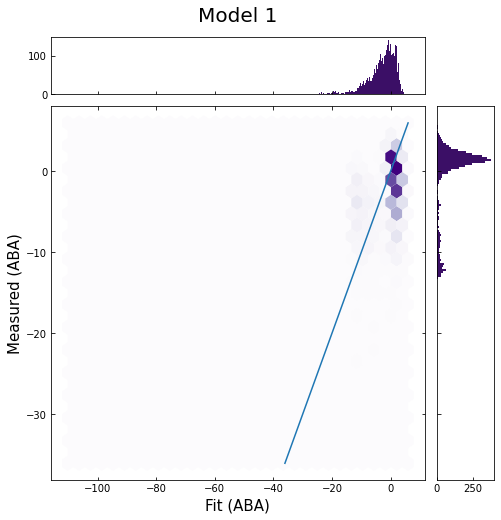

correlation is 0.3890682882207291


In [21]:
#We are using ridge regression because there are no longer outliers (we filtered them manually)

X, y = create_matrix()
reg = linear_model.Ridge(alpha=1)
reg.fit(X, y)
#This looks like the tightest regression so far
predicted_output = X @ reg.coef_ + reg.intercept_
display(vhinge(predicted_output), y, title="Model 1")
corr, p_value = pearsonr(vhinge(predicted_output), y)
print("correlation is",corr)

## Model 2
*Adding all values from vienna/mfold data*  
Due to high correlation between those values this doesn't add much predictive power to the model

In [22]:
def create_matrix2():
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 5:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                print(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                #row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])

    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y

-11.699999809265135
-10.600000381469727
-16.700000762939453
-15.100000381469727
-15.399999618530273
-15.399999618530273
-17.200000762939453
-15.399999618530273
-16.600000381469727
-11.699999809265135
-12.199999809265135
-11.300000190734865
-17.700000762939453
-13.600000381469727
-10.100000381469727
-12.199999809265135
-12.0
-10.699999809265137
-10.0
-15.100000381469727
-15.100000381469727
-15.100000381469727
-14.5
-14.699999809265135
-14.5
-12.5
-12.899999618530273
-12.699999809265135
-10.5
-10.0
-10.199999809265137
-15.699999809265135
-11.100000381469727
-11.300000190734865
-12.800000190734865
-11.199999809265137
-12.399999618530273
-15.100000381469727
-15.5
-13.0
-11.399999618530273
-10.100000381469727
-14.300000190734865
-14.399999618530273
-12.100000381469727
-11.399999618530273
-12.899999618530273
-15.100000381469727
-15.100000381469727
-15.100000381469727
-15.100000381469727
-15.100000381469727
-15.100000381469727
-14.399999618530273
-15.300000190734865
-15.300000190734865
-14.89

-14.899999618530273
-17.100000381469727
-17.200000762939453
-17.100000381469727
-17.100000381469727
-17.100000381469727
-17.100000381469727
-16.299999237060547
-17.200000762939453
-17.299999237060547
-16.5
-16.799999237060547
-15.300000190734865
-13.0
-17.0
-14.600000381469727
-15.5
-16.299999237060547
-18.100000381469727
-13.5
-19.200000762939453
-14.0
-17.299999237060547
-15.0
-17.200000762939453
-14.699999809265135
-14.600000381469727
-14.600000381469727
-17.200000762939453
-14.800000190734865
-14.800000190734865
-14.600000381469727
-18.899999618530273
-18.899999618530273
-18.899999618530273
-19.0
-18.899999618530273
-18.0
-18.200000762939453
-18.0
-16.299999237060547
-15.0
-14.699999809265135
-16.200000762939453
-17.100000381469727
-15.699999809265135
-16.200000762939453
-15.600000381469727
-14.699999809265135
-18.399999618530273
-17.200000762939453
-18.100000381469727
-17.200000762939453
-15.600000381469727
-15.600000381469727
-15.5
-14.699999809265135
-16.899999618530273
-15.0
-1

-14.199999809265135
-16.5
-13.899999618530273
-13.899999618530273
-13.899999618530273
-16.5
-13.899999618530273
-13.899999618530273
-18.100000381469727
-18.100000381469727
-18.100000381469727
-18.100000381469727
-18.100000381469727
-17.299999237060547
-17.5
-17.299999237060547
-15.600000381469727
-14.699999809265135
-14.600000381469727
-14.600000381469727
-14.899999618530273
-14.399999618530273
-14.399999618530273
-13.899999618530273
-17.700000762939453
-16.100000381469727
-15.5
-16.899999618530273
-16.700000762939453
-14.100000381469727
-14.300000190734865
-13.899999618530273
-14.0
-14.199999809265135
-15.800000190734865
-18.200000762939453
-18.100000381469727
-18.100000381469727
-18.0
-18.899999618530273
-18.0
-17.200000762939453
-18.200000762939453
-16.899999618530273
-17.700000762939453
-16.100000381469727
-14.300000190734865
-14.600000381469727
-14.199999809265135
-14.0
-16.700000762939453
-13.899999618530273
-9.800000190734863
-9.399999618530273
-12.0
-11.800000190734865
-9.80000

-13.600000381469727
-12.600000381469727
-13.800000190734865
-12.699999809265135
-13.800000190734865
-12.199999809265135
-11.399999618530273
-10.199999809265137
-9.899999618530273
-15.0
-10.899999618530273
-12.600000381469727
-10.199999809265137
-12.5
-12.5
-12.699999809265135
-12.5
-12.699999809265135
-13.0
-11.899999618530273
-11.800000190734865
-10.100000381469727
-10.199999809265137
-10.5
-12.800000190734865
-13.199999809265135
-13.199999809265135
-13.5
-11.0
-12.100000381469727
-13.199999809265135
-13.800000190734865
-12.199999809265135
-12.5
-17.399999618530273
-10.5
-11.699999809265135
-11.300000190734865
-10.300000190734863
-10.399999618530273
-12.699999809265135
-12.5
-12.899999618530273
-12.5
-12.5
-14.100000381469727
-12.399999618530273
-11.600000381469727
-12.199999809265135
-12.5
-14.199999809265135
-12.800000190734865
-12.300000190734865
-12.300000190734865
-11.600000381469727
-12.0
-9.699999809265137
-9.699999809265137
-12.399999618530273
-10.600000381469727
-11.600000381

-13.399999618530273
-10.800000190734863
-12.0
-13.199999809265135
-12.0
-12.300000190734865
-13.300000190734865
-11.5
-13.399999618530273
-11.300000190734865
-12.899999618530273
-18.399999618530273
-12.5
-12.399999618530273
-12.5
-12.5
-12.800000190734865
-12.399999618530273
-12.5
-14.699999809265135
-12.300000190734865
-11.800000190734865
-13.300000190734865
-12.399999618530273
-14.300000190734865
-13.399999618530273
-10.600000381469727
-12.800000190734865
-10.5
-10.399999618530273
-10.399999618530273
-10.600000381469727
-10.600000381469727
-15.0
-15.0
-13.199999809265135
-16.0
-13.5
-13.399999618530273
-12.300000190734865
-12.199999809265135
-12.199999809265135
-12.300000190734865
-12.300000190734865
-12.899999618530273
-12.399999618530273
-13.100000381469727
-15.699999809265135
-15.600000381469727
-14.100000381469727
-12.800000190734865
-12.399999618530273
-15.199999809265135
-15.0
-13.100000381469727
-12.5
-13.600000381469727
-16.0
-16.0
-13.199999809265135
-12.600000381469727
-12.

-12.699999809265135
-13.300000190734865
-12.800000190734865
-12.699999809265135
-13.300000190734865
-16.0
-12.300000190734865
-13.0
-12.199999809265135
-12.399999618530273
-12.199999809265135
-12.199999809265135
-12.199999809265135
-12.300000190734865
-14.300000190734865
-12.300000190734865
-14.300000190734865
-14.699999809265135
-12.600000381469727
-12.600000381469727
-12.5
-12.399999618530273
-12.800000190734865
-12.399999618530273
-12.899999618530273
-12.300000190734865
-12.699999809265135
-13.600000381469727
-13.600000381469727
-14.899999618530273
-13.399999618530273
-15.0
-13.800000190734865
-13.300000190734865
-12.899999618530273
-13.399999618530273
-12.600000381469727
-13.199999809265135
-12.5
-12.300000190734865
-12.600000381469727
-13.100000381469727
-12.300000190734865
-12.300000190734865
-14.199999809265135
-13.100000381469727
-12.300000190734865
-14.699999809265135
-12.300000190734865
-12.5
-12.199999809265135
-12.399999618530273
-12.199999809265135
-12.199999809265135
-12.

-13.699999809265135
-13.699999809265135
-13.600000381469727
-14.0
-16.299999237060547
-17.600000381469727
-16.100000381469727
-17.700000762939453
-16.600000381469727
-14.300000190734865
-13.600000381469727
-13.0
-13.800000190734865
-12.899999618530273
-12.699999809265135
-12.899999618530273
-13.399999618530273
-12.699999809265135
-16.700000762939453
-12.300000190734865
-16.0
-16.100000381469727
-14.800000190734865
-15.0
-14.899999618530273
-14.800000190734865
-14.0
-14.0
-14.0
-13.899999618530273
-14.199999809265135
-14.600000381469727
-13.600000381469727
-14.0
-13.800000190734865
-16.200000762939453
-17.5
-15.899999618530273
-17.600000381469727
-16.399999618530273
-14.600000381469727
-14.600000381469727
-14.5
-14.600000381469727
-14.600000381469727
-14.0
-14.0
-14.0
-16.700000762939453
-16.5
-15.199999809265135
-13.800000190734865
-16.0
-14.0
-13.699999809265135
-13.300000190734865
-13.0
-16.399999618530273
-12.300000190734865
-14.600000381469727
-13.300000190734865
-13.89999961853027

-16.299999237060547
-15.699999809265135
-15.600000381469727
-18.899999618530273
-19.0
-17.0
-16.799999237060547
-17.5
-17.700000762939453
-17.5
-17.399999618530273
-17.299999237060547
-17.399999618530273
-17.399999618530273
-17.399999618530273
-17.299999237060547
-17.100000381469727
-17.100000381469727
-15.600000381469727
-13.199999809265135
-13.899999618530273
-13.399999618530273
-14.300000190734865
-17.399999618530273
-16.100000381469727
-14.899999618530273
-16.5
-17.899999618530273
-17.5
-17.399999618530273
-17.399999618530273
-17.399999618530273
-17.399999618530273
-19.100000381469727
-17.899999618530273
-17.600000381469727
-15.600000381469727
-16.399999618530273
-15.699999809265135
-16.600000381469727
-15.600000381469727
-15.899999618530273
-15.800000190734865
-15.600000381469727
-15.600000381469727
-15.600000381469727
-17.0
-14.699999809265135
-17.100000381469727
-13.300000190734865
-13.0
-12.800000190734865
-13.5
-13.800000190734865
-13.600000381469727
-13.600000381469727
-13.5


-14.899999618530273
-15.899999618530273
-15.399999618530273
-14.899999618530273
-19.600000381469727
-16.399999618530273
-11.899999618530273
-9.899999618530273
-11.399999618530273
-10.199999809265137
-11.100000381469727
-13.899999618530273
-11.199999809265137
-13.300000190734865
-11.399999618530273
-10.800000190734863
-12.800000190734865
-12.800000190734865
-12.800000190734865
-12.800000190734865
-13.0
-13.199999809265135
-12.0
-12.199999809265135
-10.399999618530273
-10.899999618530273
-11.0
-17.200000762939453
-13.899999618530273
-16.700000762939453
-13.199999809265135
-16.200000762939453
-11.300000190734865
-12.300000190734865
-12.100000381469727
-14.199999809265135
-12.5
-12.5
-13.199999809265135
-13.600000381469727
-11.0
-11.899999618530273
-11.399999618530273
-10.399999618530273
-11.199999809265137
-13.0
-12.800000190734865
-13.0
-14.399999618530273
-12.699999809265135
-12.0
-12.5
-12.899999618530273
-14.600000381469727
-12.899999618530273
-12.600000381469727
-11.300000190734865
-

-16.0
-16.200000762939453
-16.0
-15.199999809265135
-15.300000190734865
-15.199999809265135
-13.5
-12.699999809265135
-12.699999809265135
-13.300000190734865
-14.100000381469727
-13.199999809265135
-13.300000190734865
-13.100000381469727
-13.699999809265135
-15.5
-16.899999618530273
-15.199999809265135
-17.0
-15.600000381469727
-13.699999809265135
-13.600000381469727
-13.5
-12.800000190734865
-13.899999618530273
-12.699999809265135
-12.699999809265135
-13.699999809265135
-16.200000762939453
-16.0
-16.100000381469727
-16.0
-15.899999618530273
-18.100000381469727
-15.899999618530273
-15.100000381469727
-15.800000190734865
-16.0
-18.399999618530273
-15.5
-16.399999618530273
-12.300000190734865
-12.199999809265135
-15.199999809265135
-17.0
-13.600000381469727
-11.300000190734865
-15.899999618530273
-11.100000381469727


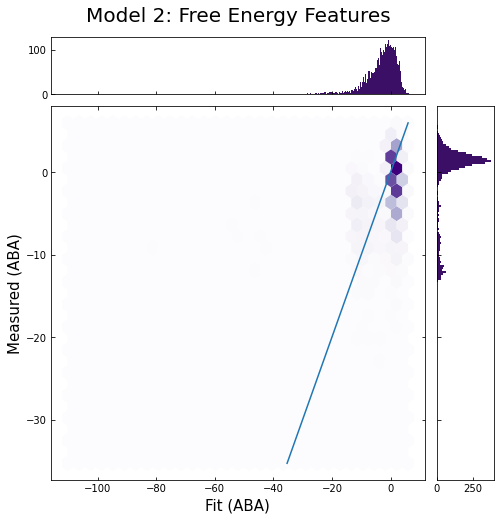

correlation is 0.40070443853866605


In [23]:
#We are using ridge regression because there are no longer outliers (we filtered them manually)

X, y = create_matrix2()
reg = linear_model.Ridge(alpha=1)
reg.fit(X, y)

predicted_output = X @ reg.coef_ + reg.intercept_
display(vhinge(predicted_output), y, title="Model 2: Free Energy Features")
corr, p_value = pearsonr(vhinge(predicted_output), y)
print("correlation is",corr)

In [24]:
X

array([[-0.12535534, -0.12718807, -0.12349711, ..., -0.11873212,
        -0.05611504,  0.74954941],
       [-0.12535534, -0.12718807, -0.12349711, ..., -0.11873212,
        -0.05611504, -0.24207465],
       [-0.12535534, -0.12718807, -0.12349711, ..., -0.11873212,
        -0.05611504,  0.65940184],
       ...,
       [-0.12535534, -0.12718807, -0.12349711, ..., -0.11873212,
        -0.05611504,  0.02836804],
       [-0.12535534, -0.12718807, -0.12349711, ..., -0.11873212,
        -0.05611504, -0.87310846],
       [-0.12535534, -0.12718807, -0.12349711, ..., -0.11873212,
        -0.05611504,  0.74954941]])

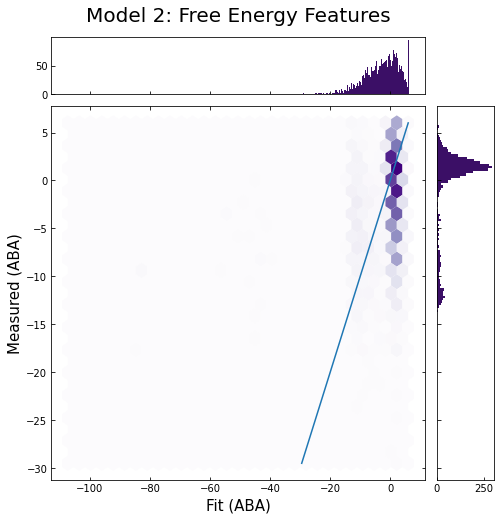

test correlation is 0.2588669804289869


In [25]:
#just to show that we aren't really over-fitting

X_train = X[:1000]
y_train = y[:1000]

X_test = X[1000:]
y_test = y[1000:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(vhinge(predicted_output), y_test, title="Model 2: Free Energy Features")
corr, p_value = pearsonr(vhinge(predicted_output), y_test)
print("test correlation is",corr)

(array([  5.,   2.,   1.,   1.,   1.,   2.,   5.,   5.,   4.,   5.,   5.,
          5.,   5.,   3.,   3.,   7.,  18.,  17.,  14.,  13.,  20.,  28.,
         31.,  37.,  47.,  40.,  49.,  58.,  79., 106., 118.,  98., 114.,
        125., 134., 117., 139., 156., 171., 166., 162., 189., 161., 200.,
        188., 144., 128., 112.,  79., 143.]),
 array([-29.46947332, -28.76008385, -28.05069438, -27.34130492,
        -26.63191545, -25.92252598, -25.21313652, -24.50374705,
        -23.79435759, -23.08496812, -22.37557865, -21.66618919,
        -20.95679972, -20.24741025, -19.53802079, -18.82863132,
        -18.11924185, -17.40985239, -16.70046292, -15.99107346,
        -15.28168399, -14.57229452, -13.86290506, -13.15351559,
        -12.44412612, -11.73473666, -11.02534719, -10.31595773,
         -9.60656826,  -8.89717879,  -8.18778933,  -7.47839986,
         -6.76901039,  -6.05962093,  -5.35023146,  -4.64084199,
         -3.93145253,  -3.22206306,  -2.5126736 ,  -1.80328413,
         -1.093894

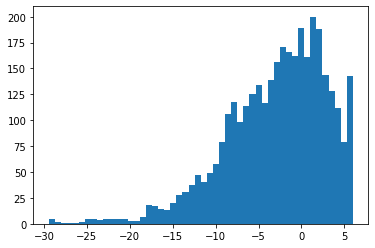

In [26]:
plt.hist(vhinge(predicted_output), bins=50)

(array([1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 4.000e+00, 5.000e+00, 4.000e+00, 1.200e+01, 9.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 2.000e+00, 4.000e+00, 6.000e+00, 9.000e+00,
        5.000e+00, 1.200e+01, 7.000e+00, 1.500e+01, 1.400e+01, 7.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.120e+02,
        2.350e+02, 1.560e+02, 9.200e+01, 1.040e+02, 7.400e+01, 1.176e+03,
        1.259e+03, 1.160e+02]),
 array([-107.35667265, -105.09004411, -102.82341557, -100.55678702,
         -98.29015848,  -96.02352994,  -93.7569014 ,  -91.49027286,
         -89.22364431,  -86.95701577,  -84.69038723,  -82.42375869,
         -80.15713015,  -77.8905016 ,  -75.62387306,  -73.35724452,
         -71.09061598,  -68.82398744,  -66.55735889,  -64.29073035,
         -62.02410181,  -59.75747327

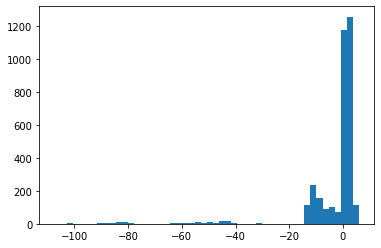

In [27]:
plt.hist(y_test, bins=50)

## Model 3
*Adding pooling values*  
The idea behind this model is that (if position is the most important factor) pooling our data should enhance the dataset and also be a good model on its own even though there are substantially less variables

In [28]:
# the start of this function is same as before
def create_matrix3():
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 5:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    
    #these are pooling values
    X_add = []
    for row in X:
        add_row = []
        #adding pooling for each position
        for gene in range(int(len(X[0])/9)):
            add_row.extend([max(row[gene*9: (gene+1)*9]), min(row[gene*9: (gene+1)*9]),
                           sum(row[gene*9: (gene+1)*9])])
        #adding pooling for group of three nucleutide positions
        for gene in range(int(len(X[0])/27)):
            add_row.extend([max(row[gene*27: (gene+1)*27]), min(row[gene*27: (gene+1)*27]),
                           sum(row[gene*27: (gene+1)*27])])
        #adding pooling for group of six nucleutide positions
        for gene in range(int(len(X[0])/54)):
            add_row.extend([max(row[gene*54: (gene+1)*54]), min(row[gene*54: (gene+1)*54]),
                           sum(row[gene*54: (gene+1)*54])])
        for gene in range(int(len(X[0])/108)):
            add_row.extend([max(row[gene*99: (gene+1)*99]), min(row[gene*99: (gene+1)*99]),
                           sum(row[gene*99: (gene+1)*99])])
        for i in range(9):
            sub_list = [row[gene*9: (gene+1)*9][i] for gene in range(int(len(X[0])/9))]
            add_row.extend([max(sub_list), min(sub_list),sum(sub_list)])
            #add_row.extend([max(sub_list)**2, min(sub_list)**2,sum(sub_list)**2])
        X_add.append(add_row)
    X_add = np.array(X_add)
    
    
    X = np.append(X, X_add, axis=1)
    
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

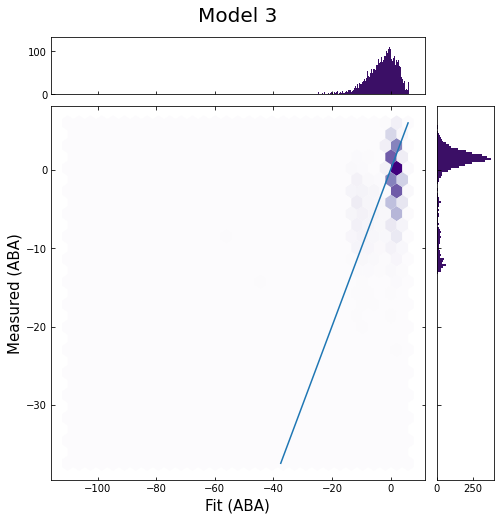

correlation is 0.4262641575600402


In [29]:
#We are using ridge regression because there are no longer outliers (we filtered them manually)

X, y = create_matrix3()
reg = linear_model.Ridge(alpha=1)
reg.fit(X, y)
#This looks like the tightest regression so far
predicted_output = X @ reg.coef_ + reg.intercept_
display(vhinge(predicted_output), y, title="Model 3")
corr, p_value = pearsonr(vhinge(predicted_output), y)
print("correlation is",corr)

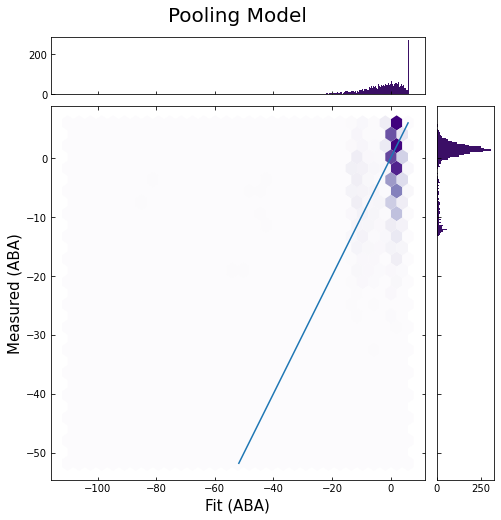

test correlation is 0.27683887686492115


In [30]:
#just to show that we aren't really over-fitting

X_train = X[:1000]
y_train = y[:1000]

X_test = X[1000:]
y_test = y[1000:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
predicted_output = X_test @ reg.coef_ + reg.intercept_
display(vhinge(predicted_output), y_test, "Pooling Model")
corr, p_value = pearsonr(vhinge(predicted_output), y_test)
print("test correlation is",corr)

**A quick look at how the different coefficients are weighted**  
I'm not really sure what to make of it

In [9]:
def hist_plot(arr):
    #print([int(elt/9) for elt in range(len(arr))])
    #print([get_action(elt) for elt in range(len(arr))])
    #print(arr)
    df = pd.DataFrame({"Position": [int(elt/9) for elt in range(len(arr))],
                        "Action": [get_action(elt) for elt in range(len(arr))],
                            "Val": arr})
    df.pivot(index = "Position", columns = "Action", values = "Val").plot.bar(edgecolor = "white", figsize=(20,10))
    plt.xticks(rotation = 0)
    # horizontal line indicating the threshold
    plt.plot([-0.5, 22], [0, 0], "k--")
    plt.show()
    
def hist_plot_count(X):
    print([int(elt/9) for elt in range(len(arr))])
    print([get_action(elt) for elt in range(len(arr))])
    print(arr)
    df = pd.DataFrame({"Position": [int(elt/9) for elt in range(len(arr))],
                        "Action": [get_action(elt) for elt in range(len(arr))],
                            "Val": arr})
    df.pivot(index = "Position", columns = "Action", values = "Val").plot.bar(edgecolor = "white", figsize=(20,10))
    plt.xticks(rotation = 0)
    # horizontal line indicating the threshold
    plt.plot([-0.5, 22], [0, 0], "k--")
    plt.show()

In [35]:
X[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [10]:
X, y = create_matrix()
reg = linear_model.Ridge(alpha=1)
reg.fit(X, y)

Ridge(alpha=1)

In [37]:
singulars = reg.predict(np.identity(len(X[0])))
arr = singulars#-reg.intercept_

In [38]:
len(arr)

198

In [39]:
X.sum(axis=0)

array([69, 71, 67, 69, 66, 61, 61,  0, 17, 62, 64, 66,  0, 65, 60, 63,  0,
        1, 61, 64, 66,  0, 69, 56, 61,  0,  0, 64, 64,  0, 65, 51, 72,  0,
       59, 15,  0, 65, 61, 64,  0, 57, 60, 75, 15, 65, 65, 65,  0, 71, 60,
       57,  0, 15, 63,  0, 63, 61, 57,  0, 73, 60, 16, 66, 62, 67,  0, 73,
       61, 62,  0, 14, 64, 68,  0, 66, 57, 68,  0, 59, 17,  0, 68, 66, 65,
        0, 59, 61, 68, 25,  0, 62, 65, 64,  0, 61, 61, 71,  1,  0, 69, 61,
       64,  0, 62, 58, 72,  0, 66, 60, 66,  0, 57, 56, 58,  0, 19,  0, 67,
       66, 70,  0, 56, 60, 63, 11, 80, 66, 65,  0, 67, 56, 57,  0, 16, 68,
       67, 70,  0, 80, 57, 59,  0,  1, 68,  0, 67, 65, 63,  0, 76, 64, 15,
        0, 69, 68, 69,  0, 62, 59, 76, 15, 67, 69,  0, 73, 62, 73,  0, 63,
       17, 68, 68,  0, 68, 60, 68,  0, 59,  1, 70, 61, 69,  0, 68, 61, 62,
        0, 14, 66,  0, 65, 67, 60,  0, 65, 62, 14])

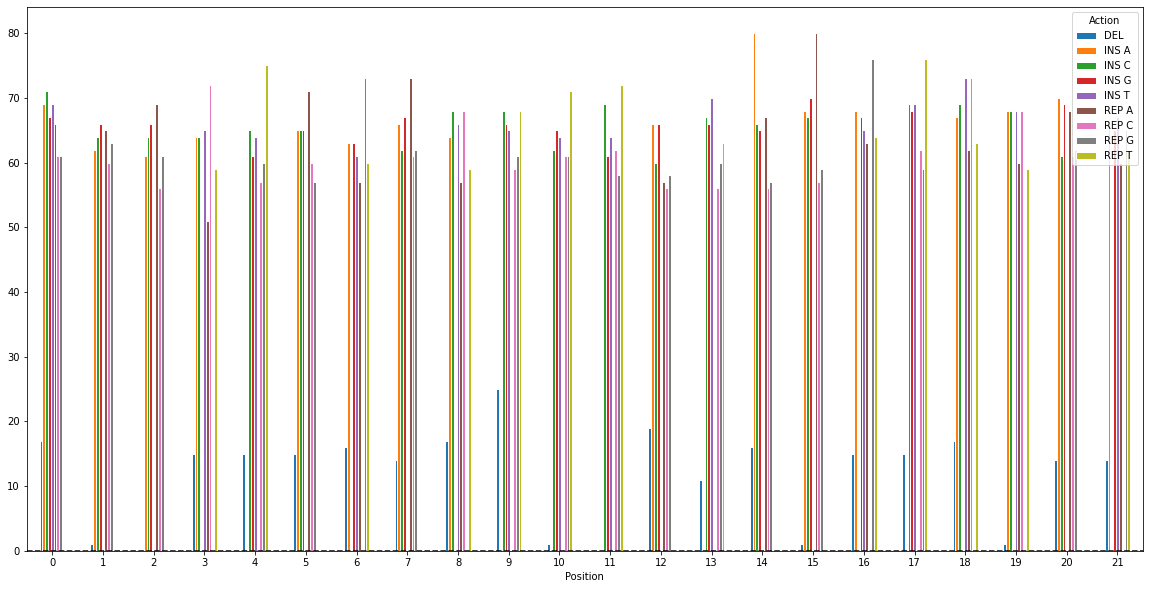

In [40]:
hist_plot(X.sum(axis=0))

In [11]:
def hist_plot_insertions(arr):
    df = pd.DataFrame({"Position": [int(elt/9) for elt in range(len(arr)) if elt % 9 in (0,1,2,3)],
                        "Action": [get_action(elt) for elt in range(len(arr)) if elt % 9 in (0,1,2,3)],
                            "Val": [arr[i] for i in range(len(arr)) if i % 9 in (0,1,2,3)]})
    df.pivot(index = "Position", columns = "Action", values = "Val").plot.bar(edgecolor = "white", figsize=(20,10))
    plt.xticks(ticks = np.arange(22),labels = list(range(1,23))[::-1],rotation = 0)
    # horizontal line indicating the threshold
    plt.plot([-0.5, 22], [0, 0], "k--")
    #plt.plot([-0.5, 22], [-reg.intercept_, -reg.intercept_], "k--")
    plt.ylabel("Normalized Linear Feature Weights", fontsize=24)
    plt.xlabel("Position", fontsize=24)
    plt.title("Weights for the Insertion Position Features", fontsize=30)
    plt.show()
def hist_plot_insertions_avg(arr):
    sub_arr = [arr[elt] for elt in range(len(arr)) if elt % 9 in (0,1,2,3)]
    #print(len(sub_arr))
    avged = np.mean(np.array(sub_arr).reshape(-1, 4), axis=1)
    df = pd.DataFrame({"Position": [int(elt/4) for elt in range(len(sub_arr)) if elt%4 == 0],
                        "Action": ["Position" for elt in range(len(sub_arr)) if elt%4 == 0],
                            "Val": avged})
    df.pivot(index = "Position", columns = "Action", values = "Val").plot.bar(edgecolor = "white",
                                                                              figsize=(20,10), legend=None)
    plt.xticks(ticks = np.arange(22),labels = list(range(1,23))[::-1],rotation = 0)
    # horizontal line indicating the threshold
    plt.plot([-0.5, 22], [0, 0], "k--")
    #plt.plot([-0.5, 22], [-reg.intercept_, -reg.intercept_], "k--")
    plt.ylabel("Normalized Linear Feature Weights", fontsize=24)
    plt.xlabel("Position", fontsize=24)
    plt.title("Average Weights for Insertion Position Features", fontsize=30)
    plt.show()

In [77]:
def hist_plot_replacements(arr):
    df = pd.DataFrame({"Position": [int(elt/9) for elt in range(len(arr)) if elt % 9 in (4,5,6,7)],
                        "Action": [get_action(elt) for elt in range(len(arr)) if elt % 9 in (4,5,6,7)],
                            "Val": [arr[i] for i in range(len(arr)) if i % 9 in (4,5,6,7)]})
    df.pivot(index = "Position", columns = "Action", values = "Val").plot.bar(edgecolor = "white", figsize=(20,10))
    plt.xticks(ticks = np.arange(22),labels = list(range(1,23))[::-1],rotation = 0)
    #plt.set_axis_direction("left")
    # horizontal line indicating the threshold
    plt.plot([-0.5, 22], [0, 0], "k--")
    #plt.plot([-0.5, 22], [-reg.intercept_, -reg.intercept_], "k--")
    plt.ylabel("Counts", fontsize=24)
    plt.xlabel("Position", fontsize=24)
    plt.title("Counts of Outliers in Substitutions (>20)", fontsize=30)
    plt.show()
def hist_plot_replacements_avg(arr):
    sub_arr = [arr[elt] for elt in range(len(arr)) if elt % 9 in (4,5,6,7)]
    #print(arr)
    #print(sub_arr)
    #print(len(arr))
    #print(len(sub_arr))
    avged = np.mean(np.array(sub_arr).reshape(-1, 4), axis=1)
    df = pd.DataFrame({"Position": [int(elt/4) for elt in range(len(sub_arr)) if elt%4 == 0],
                        "Action": ["Position" for elt in range(len(sub_arr)) if elt%4 == 0],
                            "Val": avged})
    df.pivot(index = "Position", columns = "Action", values = "Val").plot.bar(edgecolor = "white",
                                                                              figsize=(20,10), legend=None)
    plt.xticks(ticks = np.arange(22),labels = list(range(1,23))[::-1],rotation = 0)
    # horizontal line indicating the threshold
    plt.plot([-0.5, 22], [0, 0], "k--")
    #plt.plot([-0.5, 22], [-reg.intercept_, -reg.intercept_], "k--")
    plt.ylabel("Counts", fontsize=24)
    plt.xlabel("Position", fontsize=24)
    plt.title("Counts of Outliers in Substitutions (>8)", fontsize=30)
    plt.show()

In [13]:
reg.intercept_

-1.3761586408241957

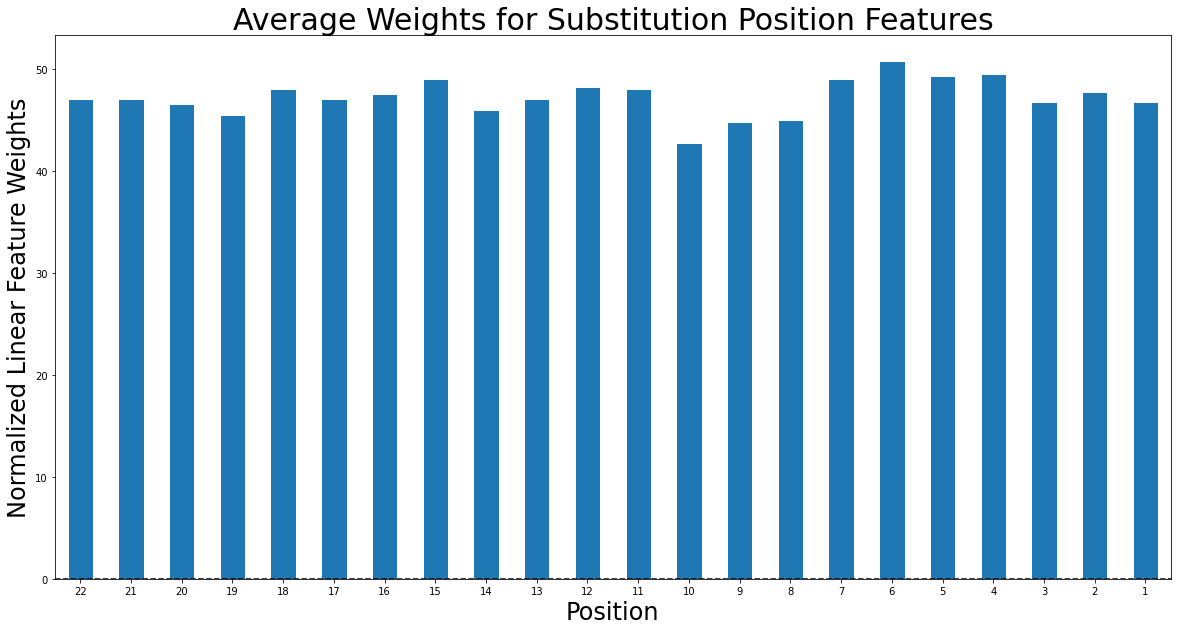

In [44]:
hist_plot_replacements_avg(X.sum(axis=0))

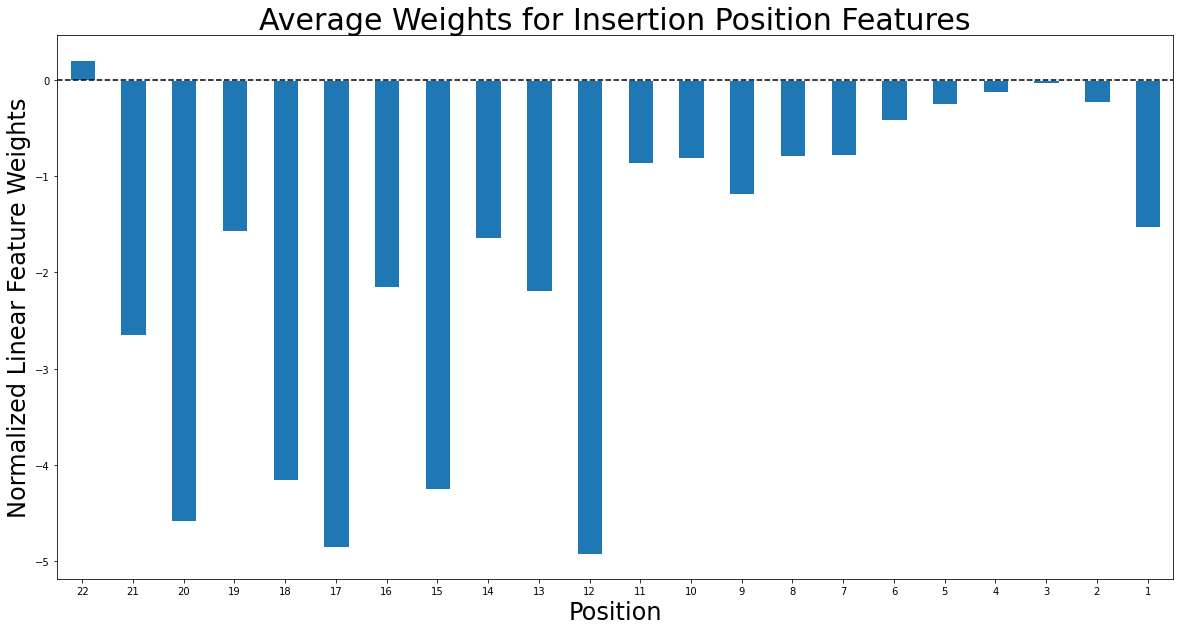

In [45]:
hist_plot_insertions_avg(arr)

In [63]:
def hist_plot_deletions(arr):
    df = pd.DataFrame({"Position": [int(elt/9) for elt in range(len(arr)) if elt % 9 in (8,)],
                        "Action": [get_action(elt) for elt in range(len(arr)) if elt % 9 in (8,)],
                            "Val": [arr[i] for i in range(len(arr)) if i % 9 in (8,)]})
    df.pivot(index = "Position", columns = "Action", values = "Val").plot.bar(edgecolor = "white",
                                                                              figsize=(20,10),fontsize=15, legend=None)
    plt.xticks(ticks = np.arange(22),labels = list(range(1,23))[::-1],rotation = 0)
    # horizontal line indicating the threshold
    plt.plot([-0.5, 22], [0, 0], "k--")
    #plt.plot([-0.5, 22], [-reg.intercept_, -reg.intercept_], "k--")
    plt.ylabel("Normalized Linear Feature Weights", fontsize=24)
    plt.xlabel("Position", fontsize=24)
    plt.title("Weights for the Deletion Position Features", fontsize=30)
    plt.show()

In [71]:
def hist_plot_avg(arr):
    avged = np.mean(np.array(arr).reshape(-1, 9), axis=1)
    df = pd.DataFrame({"Position": [int(elt/9) for elt in range(len(arr)) if elt % 9 in (8,)],
                        "Action": ["Position" for elt in range(len(arr)) if elt % 9 in (8,)],
                            "Val": avged})
    df.pivot(index = "Position", columns = "Action", values = "Val").plot.bar(edgecolor = "white",
                                                                              figsize=(20,10),fontsize=15, legend=None)
    plt.xticks(ticks = np.arange(22),labels = list(range(1,23))[::-1],rotation = 0)
    # horizontal line indicating the threshold
    plt.plot([-0.5, 22], [0, 0], "k--")
    #plt.plot([-0.5, 22], [-reg.intercept_, -reg.intercept_], "k--")
    plt.ylabel("Counts", fontsize=24)
    plt.xlabel("Position", fontsize=24)
    plt.title("Number of outliers at each position irregularity (> 8)", fontsize=30)
    #plt.get_legend().remove()
    plt.show()

In [68]:
hist_plot_deletions(arr)

NameError: name 'arr' is not defined

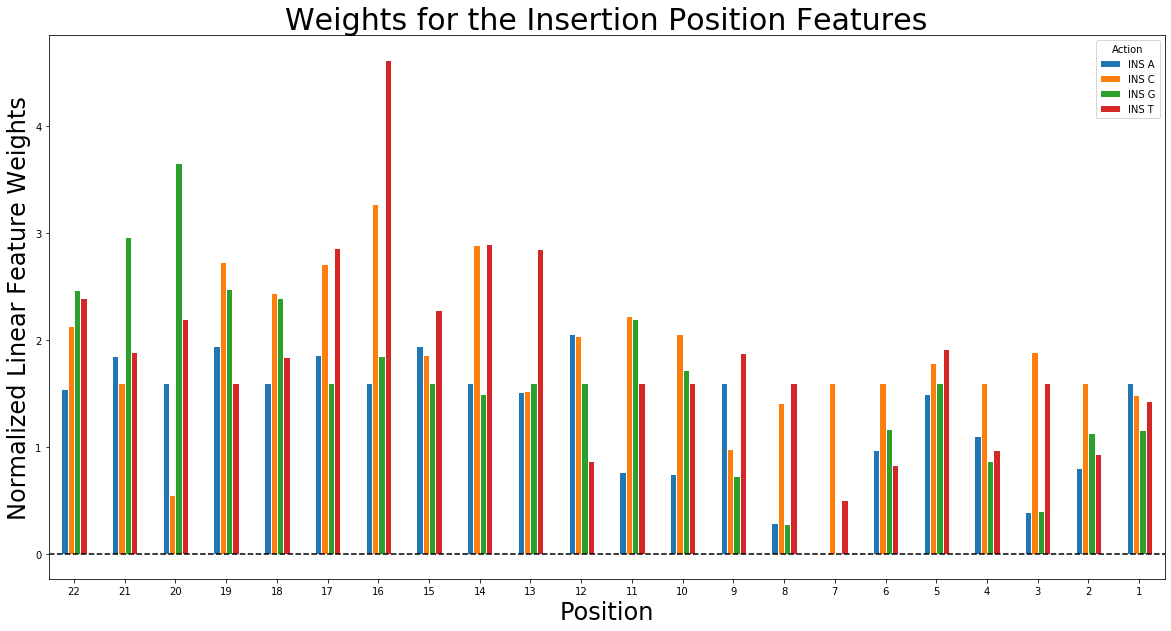

In [65]:
hist_plot_insertions(arr)

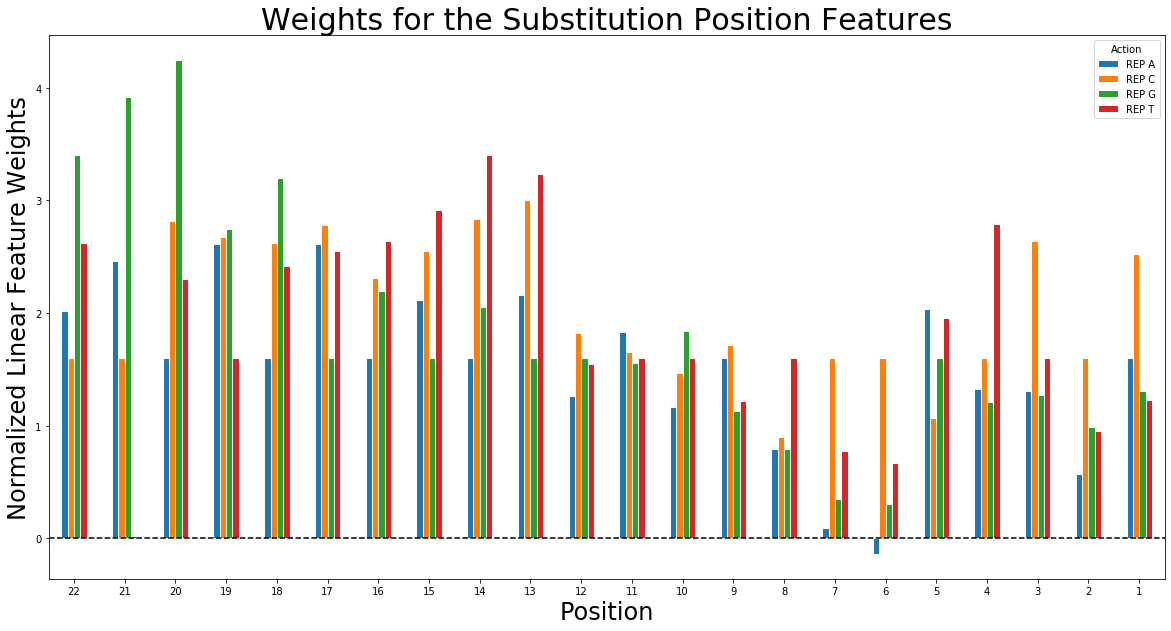

In [66]:
hist_plot_replacements(arr)

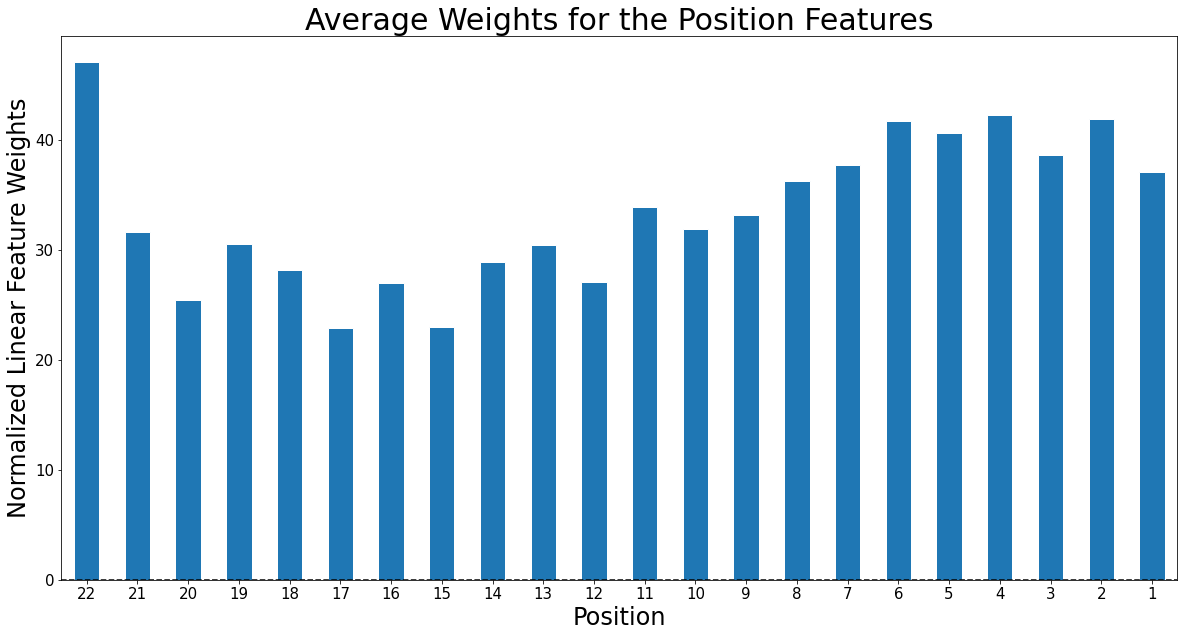

In [77]:
hist_plot_avg(X.sum(axis=0))

In [76]:
residuals = reg.predict(X)-y
big_deviations = X[[i for i in range(len(X)) if abs(residuals[i]) > 20]]

In [61]:
big_deviations.sum(axis=0)

array([ 1,  1,  0,  0,  1,  1,  2,  0,  0,  0,  3,  4,  0,  0,  0,  1,  0,
        0,  5,  4,  3,  0,  6,  3,  1,  0,  0,  2,  1,  0,  2,  1,  7,  0,
        3,  0,  0,  9,  1,  2,  0,  3,  3,  2,  4,  3,  9,  2,  0,  3, 16,
        5,  0,  3,  2,  0,  2,  0,  4,  0, 14,  0,  2,  2,  6,  3,  0, 11,
        2, 25,  0,  0,  1,  3,  0,  0,  2, 11,  0,  5,  0,  0,  4,  1,  4,
        0,  5,  3, 10,  3,  0,  2,  9,  5,  0,  3,  4,  9,  0,  0,  2,  0,
        2,  0,  2,  2,  4,  0,  1,  0,  3,  0,  4,  1,  4,  0,  0,  0,  1,
        1,  5,  0,  7,  3,  5,  1,  1,  0,  2,  0,  4,  0,  4,  0,  0,  1,
        0,  2,  0,  1,  4,  2,  0,  0,  0,  0,  2,  0,  0,  0,  2,  0,  0,
        0,  0,  1,  0,  0,  2,  0,  3,  0,  1,  0,  0,  0,  2,  1,  0,  0,
        2,  0,  0,  0,  0,  4,  3,  0,  0,  0,  0,  2,  1,  0,  0,  0,  0,
        0,  1,  2,  0,  1,  3,  2,  0,  1,  2,  0])

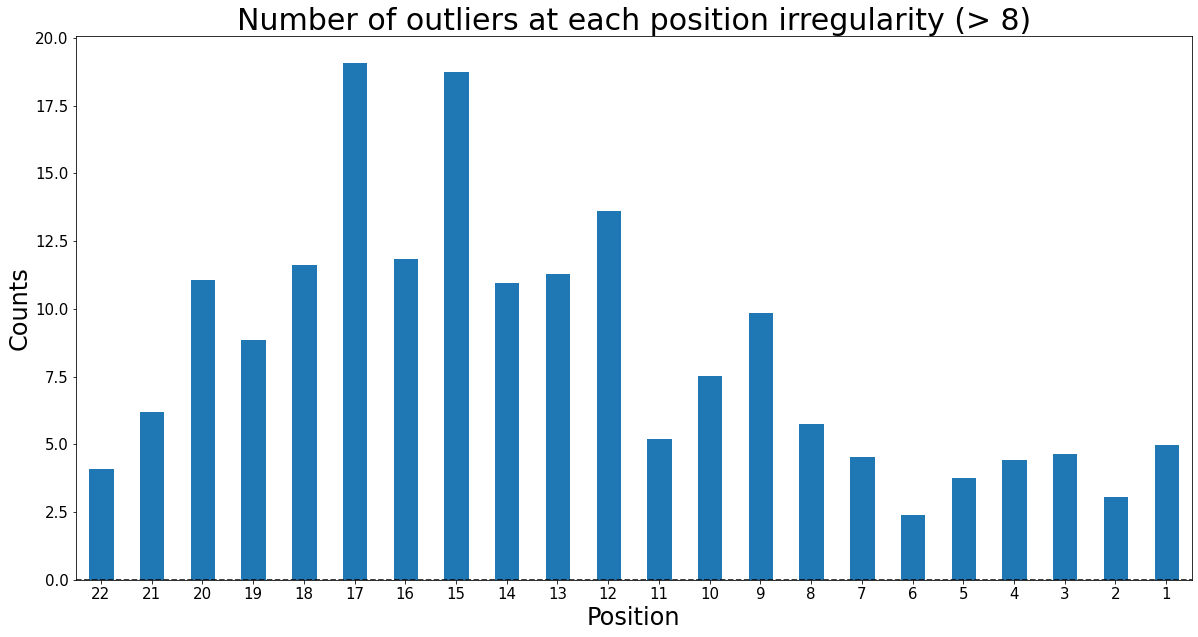

In [72]:
hist_plot_avg(big_deviations.sum(axis=0))

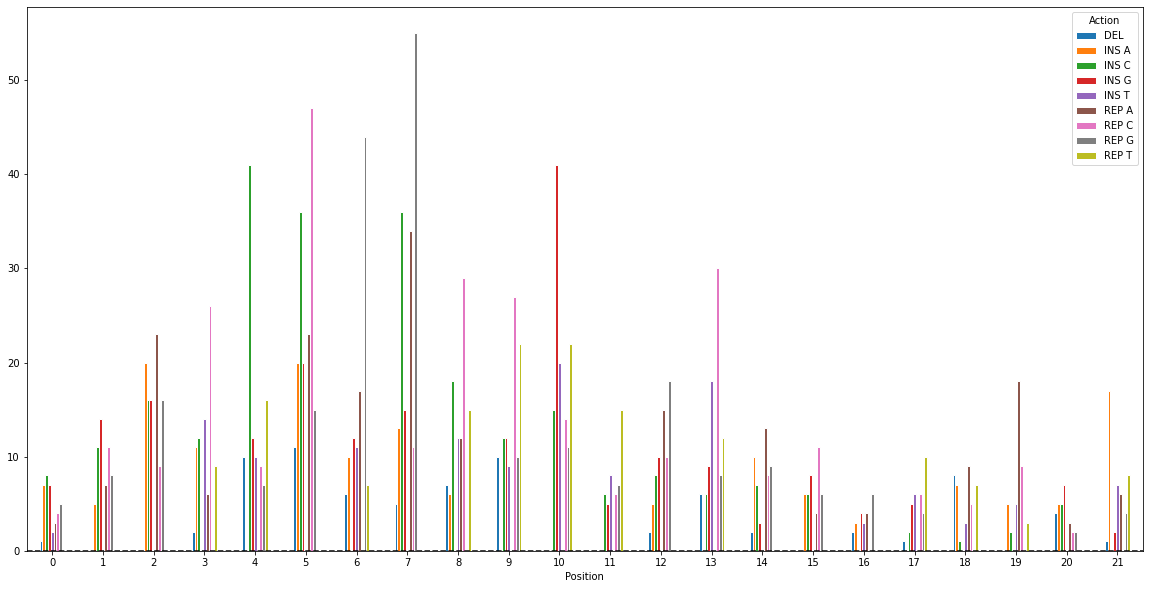

In [135]:
hist_plot(big_deviations.sum(axis=0))

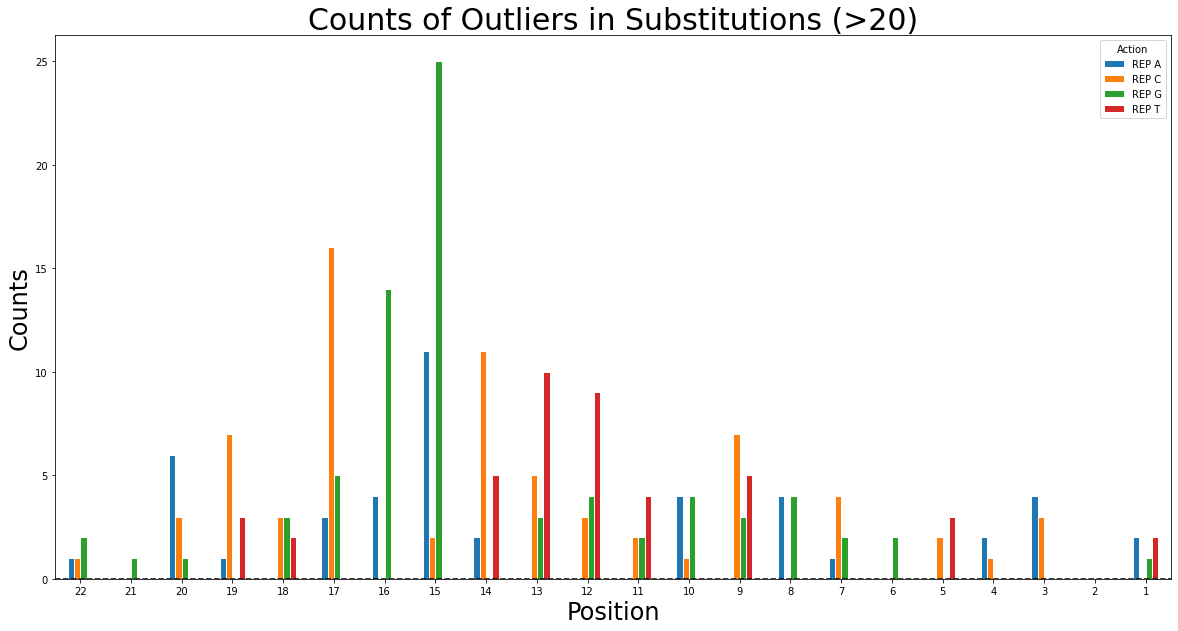

In [78]:
hist_plot_replacements(big_deviations.sum(axis=0))

**Lets look at how the added features perform on their own**

In [32]:
# the start of this function is same as before
def create_matrix3point5():
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 5:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    
    #these are pooling values
    X_add = []
    for row in X:
        add_row = []
        #adding pooling for each position
        for gene in range(int(len(X[0])/9)):
            add_row.extend([max(row[gene*9: (gene+1)*9]), min(row[gene*9: (gene+1)*9]),
                           sum(row[gene*9: (gene+1)*9])])
        #adding pooling for group of three nucleutide positions
        for gene in range(int(len(X[0])/27)):
            add_row.extend([max(row[gene*27: (gene+1)*27]), min(row[gene*27: (gene+1)*27]),
                           sum(row[gene*27: (gene+1)*27])])
        
        #adding pooling for group of six nucleutide positions
        for gene in range(int(len(X[0])/54)):
            add_row.extend([max(row[gene*54: (gene+1)*54]), min(row[gene*54: (gene+1)*54]),
                           sum(row[gene*54: (gene+1)*54])])
        for gene in range(int(len(X[0])/108)):
            add_row.extend([max(row[gene*99: (gene+1)*99]), min(row[gene*99: (gene+1)*99]),
                           sum(row[gene*99: (gene+1)*99])])
        for i in range(9):
            sub_list = [row[gene*9: (gene+1)*9][i] for gene in range(int(len(X[0])/9))]
            add_row.extend([max(sub_list), min(sub_list),sum(sub_list)])
            #add_row.extend([max(sub_list)**2, min(sub_list)**2,sum(sub_list)**2])
        X_add.append(add_row)
    X_add = np.array(X_add)
    
    ################THIS IS THE ONLY CHANGED LINE FROM ABOVE#######################
    X = X_add
    
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

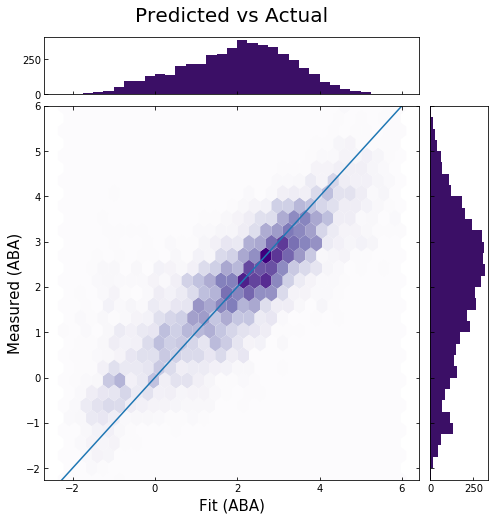

correlation is 0.8310787755285732


In [33]:
#We are using ridge regression because there are no longer outliers (we filtered them manually)

X, y = create_matrix3point5()
reg = linear_model.Ridge(alpha=1)
reg.fit(X, y)
#This looks like the tightest regression so far
predicted_output = X @ reg.coef_ + reg.intercept_
display(vhinge(predicted_output), y)
corr, p_value = pearsonr(vhinge(predicted_output), y)
print("correlation is",corr)

In [35]:
len(X[0])

129

## Model 4
*Convolution Neural Network Model (CNN)*
As you can see from above, pooling (without even using the energy values we calculated) still has a pretty high r value. The process we used on our data resembles a very primitive CNN with a pooling and simple linear activation. We now try to see if we can actually create a net that has high training and test accuracy

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
# the start of this function is same as before
def create_matrix4():
    max_len = 0
    for seq in seq_aba_pairs:
        max_len = max(max_len, len(seq))
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 5:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                #row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    
    #these are pooling values
    X_add = []
    for row in X:
        add_row = []
        #adding pooling for each position
        for gene in range(int(len(X[0])/9)):
            add_row.extend([max(row[gene*9: (gene+1)*9]), min(row[gene*9: (gene+1)*9]),
                           sum(row[gene*9: (gene+1)*9])])
        #adding pooling for group of three nucleutide positions
        for gene in range(int(len(X[0])/27)):
            add_row.extend([max(row[gene*27: (gene+1)*27]), min(row[gene*27: (gene+1)*27]),
                           sum(row[gene*27: (gene+1)*27])])
        #adding pooling for group of six nucleutide positions
        for gene in range(int(len(X[0])/54)):
            add_row.extend([max(row[gene*54: (gene+1)*54]), min(row[gene*54: (gene+1)*54]),
                           sum(row[gene*54: (gene+1)*54])])
        for gene in range(int(len(X[0])/108)):
            add_row.extend([max(row[gene*99: (gene+1)*99]), min(row[gene*99: (gene+1)*99]),
                           sum(row[gene*99: (gene+1)*99])])
        for i in range(9):
            sub_list = [row[gene*9: (gene+1)*9][i] for gene in range(int(len(X[0])/9))]
            add_row.extend([max(sub_list), min(sub_list),sum(sub_list)])
        row = [0 for i in range(4*max_len)]
        for i in range(len(seq)):
            if seq[i] == 'A':
                row[i*4 + 0] = 1
            elif seq[i] == 'C':
                row[i*4 + 1] = 1
            elif seq[i] == 'G':
                row[i*4 + 2] = 1
            elif seq[i] == 'T':
                row[i*4 + 3] = 1
            else:
                print("Impossible happened check seq values", seq)
        add_row.extend(row)
        X_add.append(add_row)
    X_add = np.array(X_add)
    
    
    X = np.append(X, X_add, axis=1)
    #X = np.append(X, create_matrix_0(randomize=False)[0], axis=1)
    
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

In [43]:
#make sure to install keras if you don't have the package yet
from keras import layers, models

In [44]:
#returns a CNN model given training data
def train(X, y, batch_size=100, epochs=100):
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    y_ = y.reshape(len(y), 1)
    print("input shaped", (len(X[0]), 1, 1))
    
    model = models.Sequential()
    #model.add(layers.Conv2D(16, (3, 1), activation='relu', input_shape=(len(X[0]), 1, 1)))
    #model.add(layers.MaxPooling2D((3, 1)))
    #model.add(layers.Conv2D(32, (9, 1), activation='relu', input_shape=(len(X[0]), 1, 1)))
    #model.add(layers.MaxPooling2D((3, 1)))
    model.add(layers.Conv2D(64, (54, 1), activation='relu', input_shape=(len(X[0]), 1, 1)))
    model.add(layers.MaxPooling2D((3, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1, activation='linear'))
    model.summary()
    
    

    #model.compile(loss='mean_squared_error',
    #              optimizer='sgd')
    model.compile(loss='logcosh',
                  optimizer='sgd')
    model.fit(X_, y_,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1
              )
    return model

#fits the data based on the trained model from above
def fit(model, X, y):
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    display(vhinge(model.predict(X_)).reshape(len(X_)), y)
    
    corr, p_value = pearsonr(vhinge((model.predict(X_)).reshape(len(X_))), y)
    print("corr is", corr)
    #return vhinge((model.predict(X_)).reshape(len(X_))), y
    
# no longer necessary  
def without_outliers(model, X, y):
    outliers = []
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    predictions = vhinge((model.predict(X_)).reshape(len(X_)))
    for i in range(len(predictions)):
        if predictions[i]-y[i] > 3:
            print("removing", predictions[i], y[i])
            predictions = np.delete(predictions, i)
            y.pop(i)

In [53]:
X, y = create_matrix4()

input shaped (439, 1, 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 386, 1, 64)        3520      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 1, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                524352    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 527,937
Trainable params: 527,937
Non-trainable params: 0
_________________________________________________________________

Epoch 1/100
4000/4000 [==============================] - 1s 327us/step - loss: 0.5527
E

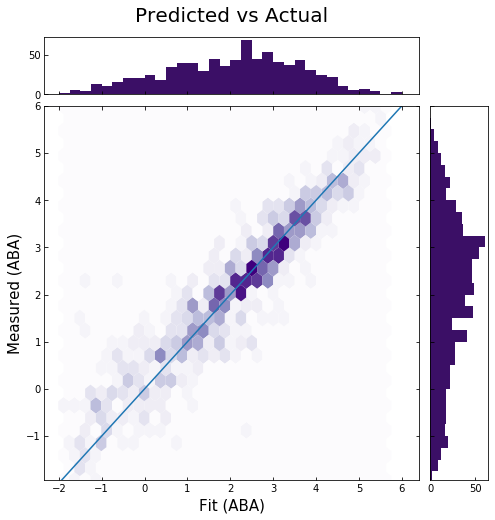

corr is 0.9319014116632276


In [45]:
#this will take 5 minutes to run
X_train = X[:4000]
X_test = X[4000:]

y_train = y[:4000]
y_test = y[4000:]

model = train(X_train, y_train, epochs=100)
fit(model, X_test, y_test)

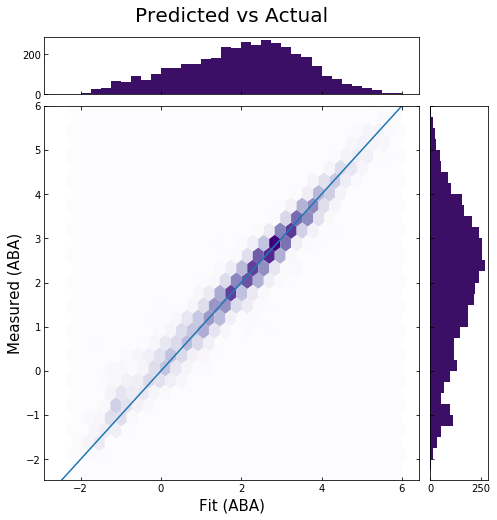

corr is 0.9759359434131396


In [46]:
fit(model, X_train, y_train)

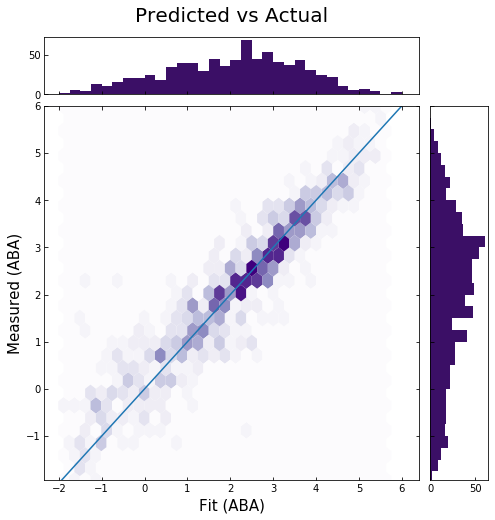

corr is 0.9319014116632276


In [47]:
fit(model, X_test, y_test)

In [19]:
def fit_v_meas_plot(x, loc_data, pamlen, del_trunc=1, model_func=None):
    width_ratios = [1, 6, 1]
    height_ratios = [1, 6, 1]
    gs = mpl.gridspec.GridSpec(3, 3, width_ratios=width_ratios, height_ratios=height_ratios, 
                               wspace=0.1, hspace=0.1,
                               bottom=0.0, top=1.0, left=0.0, right=1.0)
    fig = plt.figure(figsize=(sum(width_ratios), sum(height_ratios)))

    all_meas, all_fit = get_all_meas_and_fit(x, loc_data, pamlen, del_trunc, model_func)
    zbl, ztr, zxr, zxl, zyb, zyt, new_x, new_y, not_corner_x, not_corner_y = split_data(all_meas, all_fit)
    r, pval = pearsonr(all_meas, all_fit)
    center_r, _ = pearsonr(new_x, new_y)
    not_corner_r, _ = pearsonr(not_corner_x, not_corner_y)
    lim = (log10_lb - 1, log10_ub + 1)

    # Corners
    ax = plt.subplot(gs[2])
    ax.text(0, 0, '$(ub, ub)$\n$%.0f$%%' % (100*float(ztr)/len(all_meas)), 
            fontsize=16, ha='center', va='center')
    ax = plt.subplot(gs[6])
    ax.text(0, 0, '$(lb, lb)$\n$%.0f$%%' % (100*float(zbl)/len(all_meas)), 
            fontsize=16, ha='center', va='center')
    for idx in [0, 2, 6, 8]:
        ax = plt.subplot(gs[idx])
        ax.set_xticks([]); ax.set_yticks([])
        ax.axis('off')
        ax.set_xlim((-0.5, 0.2))
        ax.set_ylim((-0.5, 0.2))
    

    # Correlation Plot
    ax = plt.subplot(gs[4])
    #ax.hexbin(new_x, new_y, gridsize=30, cmap='Greys', mincnt=1, vmin=0, vmax=0.005*len(new_x))
    ax.scatter(new_x, new_y, c=density_color(new_x, new_y), cmap='viridis', edgecolors='none')
    #ax.scatter(all_meas, all_fit, c=density_color(all_meas, all_fit), cmap='viridis', edgecolors='none')
    ax.text((lim[0] + lim[1])/2, (11*lim[0] + lim[1])/12, '$r = %.2f,\ r_c = %.2f,\ r_{nc} = %.2f$' % (r, center_r, not_corner_r), 
            fontsize=18, ha='center', va='center')
    ax.set_aspect(1)
    ax.legend(loc='lower right')

    ax.plot(lim, lim, 'k--', alpha=0.5)
    ax.set_xlim(lim); ax.set_ylim(lim)
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    # hist stuff
    max_pct = 20
    h = float(max_pct)/100 * len(all_meas)
    loc_frac = 0.85
    nbins = 30
    text_pos = log10_lb + 1*data_span
    
    # XL hist
    ax = plt.subplot(gs[3])
    bins = np.linspace(lim[0], lim[1], nbins)
    ax.hist(zxl, bins, histtype='step', orientation='horizontal', color='grey')
    ax.set_xlim((h, 0))
    ax.set_xticklabels([]); 
    ax.set_xticks((0, h))
    ax.set_xticklabels((0, '{}%'.format(max_pct)))
    #ax.set_xlabel('$(0, y)$')
    ax.set_ylim(lim)
    ax.text(h/2, text_pos, '$(lb, y)$\n$%.0f$%%' % (100*float(len(zxl))/len(all_meas)), 
            fontsize=16, ha='center', va='center')
    ax.set_ylabel('Fit log10 Cleavage Rate ($s^{-1}$)')
    
    # XR hist
    ax = plt.subplot(gs[5])
    bins = np.linspace(lim[0], lim[1], nbins)
    ax.hist(zxr, bins, histtype='step', orientation='horizontal', color='grey')
    ax.set_xlim((0, h))
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.set_xticks((0, h))
    ax.set_xticklabels((0, '{}%'.format(max_pct)))
    #ax.set_xlabel('$(0, y)$')
    ax.set_ylim(lim)
    ax.text(h/2, text_pos, '$(ub, y)$\n$%.0f$%%' % (100*float(len(zxr))/len(all_meas)), 
            fontsize=16, ha='center', va='center')
    
    # YB hist
    ax = plt.subplot(gs[7])
    bins = np.linspace(lim[0], lim[1], nbins)
    ax.hist(zyb, bins, histtype='step', color='grey')
    ax.set_ylim((h, 0))
    ax.set_yticks((0, h))
    ax.set_yticklabels([])
    ax.set_yticklabels((0, '{}%'.format(max_pct)))
    #ax.set_ylabel('$(x, 0)$')
    ax.set_xlim(lim)
    ax.text(text_pos, h/2, '$(x, lb)$\n$%.0f$%%' % (100*float(len(zyb))/len(all_meas)), 
            fontsize=16, ha='center', va='center')
    ax.set_xlabel('Measured log10 Cleavage Rate ($s^{-1}$)')

    # YT hist
    ax = plt.subplot(gs[1])
    bins = np.linspace(lim[0], lim[1], nbins)
    ax.hist(zyt, bins, histtype='step', color='grey')
    ax.set_ylim((0, h))
    ax.set_yticks((0, h))
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.set_yticklabels((0, '{}%'.format(max_pct)))
    #ax.set_ylabel('$(x, 0)$')
    ax.set_xlim(lim)
    ax.text(text_pos, h/2, '$(x, ub)$\n$%.0f$%%' % (100*float(len(zyt))/len(all_meas)), 
            fontsize=16, ha='center', va='center')

    print_minus_zeros_r(all_meas, all_fit)
    return fig, ax

NameError: name 'single_effects' is not defined

In [130]:
# to help analyze results
import matplotlib as mpl
def display1(predicted, actual):
    x,y = actual,predicted
    
    
    
    # definitions for the axes
    left, width = 0.02, 0.65
    bottom, height = 0.2, 0.65
    spacing = 0.02


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    #plt.title("Predicted vs Expected ABA for Linear Regression Model")



    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    #ax_scatter.scatter(predicted, actual)
    ax_scatter.hexbin(x, y, gridsize=(30,15),  cmap='Purples', edgecolors='none' )
    ax_scatter.plot(np.unique(predicted), np.poly1d(np.polyfit(x,
                                                x, 1))(np.unique(y)))

    ax_scatter.set_xlabel("Fit (ABA)", fontsize=15)
    ax_scatter.set_ylabel("Measured (ABA)", fontsize=15)
    # now determine nice limits by hand:
    binwidth = 0.25
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    #ax_scatter.set_xlim((-lim, lim))
    #ax_scatter.set_ylim((-lim, lim))

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins,  color=(0.23, 0.06, 0.4))
    ax_histx.set_title('Predicted vs Measured ABA',pad=15, fontsize=20)
    ax_histy.hist(y, bins=bins, orientation='horizontal',color=(0.23, 0.06, 0.4))

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    

    plt.show()
    
    

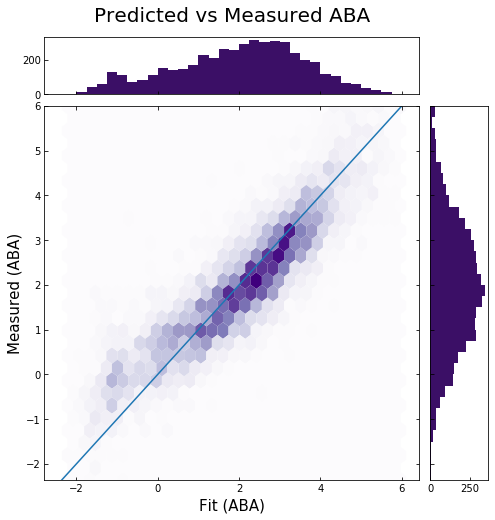

In [131]:
display1(vhinge(predicted_output), y)

In [616]:
#Plots detailed results
def display1(predicted, actual, title="Predicted vs Actual"):
    x,y = actual,predicted
    
    
    
    # definitions for the axes
    left, width = 0.02, 0.65
    bottom, height = 0.2, 0.65
    spacing = 0.02


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    #plt.title("Predicted vs Expected ABA for Linear Regression Model")



    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    #ax_histx = plt.axes(rect_histx)
    #ax_histx.tick_params(direction='in', labelbottom=False)
    #ax_histy = plt.axes(rect_histy)
    #ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    #ax_scatter.scatter(predicted, actual)
    ax_scatter.hexbin(x, y, gridsize=(30,15),  cmap='Purples', edgecolors='none' )
    #ax_scatter.plot(np.unique(predicted), np.poly1d(np.polyfit(x,
    #                                            x, 1))(np.unique(y)))

    ax_scatter.set_xlabel("Free Energy (kcal/mol)", fontsize=15)
    ax_scatter.set_ylabel("Measured (ABA)", fontsize=15)
    # now determine nice limits by hand:
    binwidth = 0.25
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    plt.title(title, fontsize=20)
    #ax_scatter.set_xlim((-lim, lim))
    #ax_scatter.set_ylim((-lim, lim))

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    #ax_histx.hist(x, bins=bins,  color=(0.23, 0.06, 0.4))
    #ax_histx.set_title(title,pad=15, fontsize=20)
    #ax_histy.hist(y, bins=bins, orientation='horizontal',color=(0.23, 0.06, 0.4))

    #ax_histx.set_xlim(ax_scatter.get_xlim())
    #ax_histy.set_ylim(ax_scatter.get_ylim())
    

    plt.show()

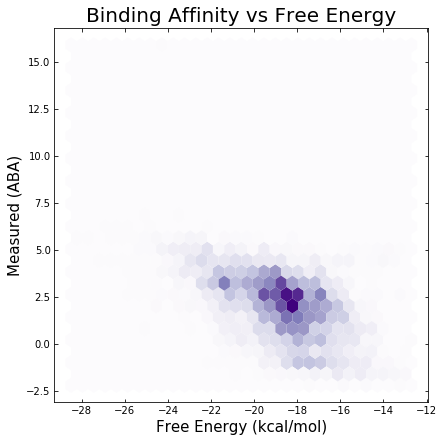

In [617]:
#display1(big_table.vienna_opt,big_table.ABA,"Hi")
display1(big_table.ABA,big_table.vienna_opt,title="Binding Affinity vs Free Energy")

In [428]:
corr, p_value = pearsonr(big_table.vienna_opt, big_table.ABA)

In [429]:
corr

-0.5257564276433702

In [7]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

regr = OLS(y, add_constant(X)).fit()
print(regr.aic)

11929.188810248968


In [17]:
X, y = create_matrix4()

NameError: name 'create_matrix4' is not defined

In [54]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

regr = OLS(y, add_constant(X)).fit()
print(regr.aic)

9552.611397937619


In [ ]:
#full model with pooling is 9498.39
#model with free energy is 10671.60
#original model aic is 11929.18
#pooling model aic is 12683.97
#absolute model aic is 15050.81

"\nfig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)\naxs[0].bar(names, values)\naxs[1].scatter(names, values)\naxs[2].plot(names, values)\nfig.suptitle('Categorical Plotting')\n"

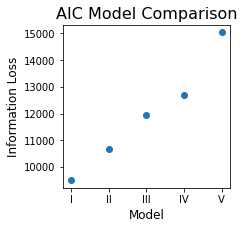

In [68]:
import matplotlib.pyplot as plt

data = {'I': 9498.39, 'II': 10671.60, 'III': 11929.18, 'IV': 12683.97, "V": 15050.81}
names = list(data.keys())
values = list(data.values())
plt.figure(figsize=(3, 3))
plt.ylabel("Information Loss", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.title("AIC Model Comparison", fontsize=16)
plt.scatter(names,values)
"""
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].bar(names, values)
axs[1].scatter(names, values)
axs[2].plot(names, values)
fig.suptitle('Categorical Plotting')
"""

In [ ]:
axs[1].scatter(names, values)

# Looking at outliers

In [14]:
X, y, seq = create_matrix(get_seq = True)

In [15]:
#seq

In [16]:
import h5py
filepath = 'For Jami/0803_cr7_intensities'
f = h5py.File(filepath,'r')
a_group_key = list(f.keys())[0]
dset = f[a_group_key]
d= dset[:]
df = pd.DataFrame(d)
df.sequence = df.sequence.str.decode('utf-8')

In [17]:
df.head()

,sequence,median intensties
0,TTTGATCTGAAATATAGTCCTC,"[5924.6208755714215, 6672.256511422405, 7027.0..."
1,TTTGACTAAATATTCAGGTC,"[7886.635524101301, 8517.277643781206, 8828.94..."
2,TGTTATCTGAAATATTCAGGTC,"[10620.833055780044, 10342.965232244012, 10610..."
3,TTTGATCTGATACATATTCAGGTC,"[6328.803565593105, 6827.525546735309, 6702.06..."
4,TTTGATCTGAAATCTTCAAGTC,"[9640.404512417408, 9008.02510752511, 9707.422..."


In [18]:
residuals = pd.DataFrame()
residuals['sequence'] = seq
residuals['resid'] = reg.predict(X)-y

In [19]:
residuals.tail()

,sequence,resid
4455,TTTTGGATCTGAAATATTCAGGTC,-2.455417
4456,TTTTGTATCTGAAATATTCAGGTC,-2.246859
4457,TTTTGTCTGAAATATTCAGGTC,-4.663763
4458,TTTTTGATCTGAAATATTCAGGTC,4.042175
4459,TTTTTTCTGAAATATTCAGGTC,52.212356


In [20]:
df.tail()

,sequence,median intensties
4901,TTTGATCTGAACTTTTCAGGTC,"[5858.831778811287, 6428.025035800958, 7259.72..."
4902,TGCGATCTGAAATATTCAGGTC,"[8715.616802538818, 8271.62079883513, 8925.244..."
4903,TTTGATCCTGATAATATTCAGGTC,"[8265.410347957313, 7396.844066740745, 8123.73..."
4904,TTTGATCTGAAATATGTCTAGGTC,"[7940.699271769103, 8252.448441311935, 8414.27..."
4905,TTTGAGCTGAAATATTCAGGCC,"[6026.981859937761, 6545.036304241614, 7389.67..."


In [138]:
data.tail()

,sequence,kd,kd_uncertainty,y_intercept,delta_y,count
4899,TTTGATCTGAATATATTCAGGGTC,0.054608,1.227150e-01,17477.020718,12052.880303,123
4900,TTTGATCTGAACTTTTCAGGTC,1631.675442,1.985209e+06,10082.118953,39186.015309,136
4901,TTTCTAGACTTTATAAGTCCAG,0.000705,3.568719e+04,1.645299,10236.337586,119
4902,TTTGATCTGAAATATATCAGAGTC,96.653864,2.224493e+01,9768.408932,19798.877704,154
4903,TTTGATCTGAAATATGTCTAGGTC,30.207337,1.763293e+00,9131.949498,33127.855984,113


In [25]:
merged = pd.merge(residuals, data, on='sequence', how='inner')

In [26]:
merged.head()

,sequence,resid,kd,kd_uncertainty,y_intercept,delta_y,count
0,AAACATCTGAAATATTCAGGTC,-5.724824,140.890323,5.167373e+01,10011.784123,21460.274661,146
1,AAACTTCTGAAATATTCAGGTC,1.008072,118.002043,8.086563e+01,11127.251026,20736.416482,96
2,AAAGATCTGAAATATTCAGGTC,-0.214564,503.495412,1.190164e+06,11280.888359,27548.995699,131
3,AATGATCTGAAATATTCAGGTC,5.912840,38.616811,4.021422e+00,11712.023978,24767.460104,131
4,ACTGATCTGAAATATTCAGGTC,-2.679798,37.700599,5.485702e+00,10030.149794,21991.900908,103


In [34]:
np.linalg.norm(merged.resid)**2/len(merged.resid)

140.66077804544219

In [54]:
filtered = merged[(merged['kd'] > 1) & (merged['kd_uncertainty'] < 10) & (merged['delta_y'] > 15000) & (merged['delta_y'] - merged['y_intercept'] > 3000)]
np.linalg.norm(filtered.resid)**2/len(filtered.resid)

132.711632214961

In [49]:
filtered

,sequence,resid,kd,kd_uncertainty,y_intercept,delta_y,count
0,AAACATCTGAAATATTCAGGTC,-5.724824,140.890323,51.673733,10011.784123,21460.274661,146
1,AAACTTCTGAAATATTCAGGTC,1.008072,118.002043,80.865628,11127.251026,20736.416482,96
3,AATGATCTGAAATATTCAGGTC,5.912840,38.616811,4.021422,11712.023978,24767.460104,131
4,ACTGATCTGAAATATTCAGGTC,-2.679798,37.700599,5.485702,10030.149794,21991.900908,103
5,AGTGATCTGAAATATTCAGGTC,-5.439350,72.044135,22.018533,10372.857293,19793.843296,119
...,...,...,...,...,...,...,...
4453,TTTTGATTCTGAAATATTCAGGTC,-1.247909,190.395772,78.007401,11566.870117,26211.539856,148
4454,TTTTGCATCTGAAATATTCAGGTC,-6.298774,45.910990,6.012169,8942.879824,19173.563020,105
4456,TTTTGTATCTGAAATATTCAGGTC,-2.246859,62.374089,17.371669,10530.503433,19953.551698,108
4457,TTTTGTCTGAAATATTCAGGTC,-4.663763,231.135305,375.229849,10415.456416,29068.806973,145


In [ ]:
len(merged[merged['kd'] < 10].resid

In [57]:
merged.shape

(4460, 7)

In [55]:
filter1 = merged[(merged['delta_y'] - merged['y_intercept'] > 3000)]

In [56]:
filter1.shape

(3401, 7)

In [58]:
np.linalg.norm(filter1.resid)**2/len(filter1.resid)

146.31928538369584